# 2. Candidates Generate

- Customer에게 article을 추천해주기 위한 모델을 만드는데, 2-stage로 모델을 구성할 예정이다. 첫번째 단계에선 추천할 후보군을 선정하는 Candidates 모델을, 두번째 단계에선 선정한 candidate들의 ranking을 산정하여 각 customer마다 높은 랭킹의 article을 12개씩 추천하는 모델을 만들 것이다.
- 이를 위해 해당 notebook에선 첫번째 단계에 해당하는 추천할 후보 candidate들을 생성하는 작업을 진행할 예정이다.
- 각각의 chapter마다 얻어낸 결론들이나 핵심적인 아이디어들을 ***Italic Bold***체로 적어놓았다.

<hr>

# Index

## 0. Train-Validation Split

## 1. Candidates Generate
    - 1-1. Same Product_code
    - 1-2. Weekly & Monthly & Age-wise Best-Seller
    - 1-3. Contents based Filtering
    - 1-4. Graph Embedding(almost User-based Collaborative Filtering)
    
## 2. Candidates Recall Test
    - Exclusive Candidates Test
    - Inclusive Candidates Test
    - 성능 평가에 대한 고찰
<hr>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
from datetime import datetime, timedelta
from collections import defaultdict

In [2]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [3]:
articles = pd.read_csv('articles.csv')
customers = pd.read_csv('customers.csv')
transactions = pd.read_csv('transactions_train.csv')
sample_submissions = pd.read_csv('sample_submission.csv')

## 0. Train-Validation Split
<hr>

In [4]:
# 판매 log 데이터의 최초 날짜와 최종날짜
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'], format='%Y-%m-%d')
first_date, last_date = min(transactions['t_dat']), max(transactions['t_dat'])
print(first_date, last_date)

2018-09-20 00:00:00 2020-09-22 00:00:00


In [5]:
# 최근 1주 전
last_one_week = last_date + timedelta(weeks=-1, days=1)
last_one_week

Timestamp('2020-09-16 00:00:00')

- 결국 모델을 통해 최종적으로 도출한 결과물을 통해 맞춰야 할 결과물은, ```transactions_train.csv```에 기록된 판매 log의 마지막 판매 날짜 이후부터 일주일간 판매될 article들이다. 모델 training동안 이를 근사하기 위한 합리적인 validation 데이터는, test 데이터와 가장 가까운 날짜이면서도 같은 기간인 'transactions_train.csv'의 마지막 일주인간의 기록일 것이다. 2020년 9월 22일이 주어진 training 데이터의 마지막 날짜이므로 test 데이터는 2020년 9월 23일부터 9월 29일까지이겠고, 우리가 모델을 training 시키면서 성능을 가늠할 때 사용할 validation 데이터는 2020년 9월 16일부터 9월 22일까지의 데이터이다.

In [6]:
# 최근 일주일간 판매된 article들의, training 데이터 전체에 대한 집계
last_week_article = transactions[transactions['t_dat']>=last_one_week]['article_id'].unique()

last_week_article_df = transactions[transactions['article_id'].isin(last_week_article)]['t_dat'].value_counts()
last_week_article_df = last_week_article_df.reset_index()
last_week_article_df.columns = ['date', 'Sales_num']
last_week_article_df = last_week_article_df.sort_values(by='date')

last_week_moving_average_df = last_week_article_df.copy()
last_week_moving_average_df['Sales_num'] = last_week_moving_average_df['Sales_num'].rolling(window=28).mean()
last_week_moving_average_df['Sales_num'] = last_week_moving_average_df['Sales_num']\
                                           .fillna(min(last_week_moving_average_df['Sales_num']))

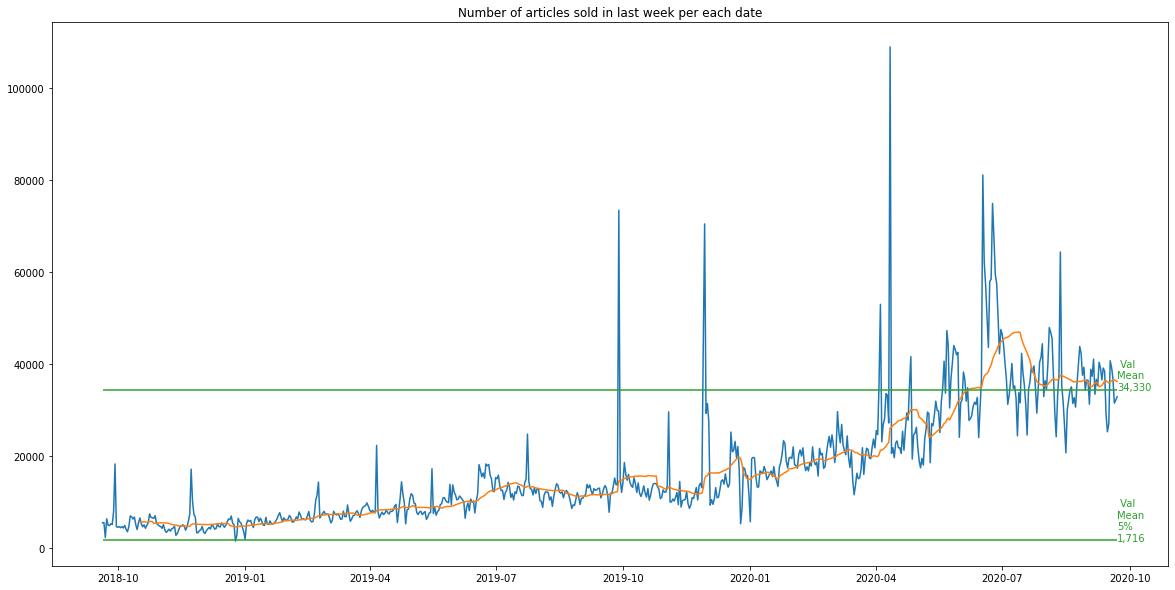

In [10]:
plt.figure(figsize = (20, 10))
plt.title('Number of articles sold in last week per each date')
plt.plot('date', 'Sales_num', data=last_week_article_df)
plt.plot('date', 'Sales_num', data=last_week_moving_average_df)

plt.hlines(1716, min(last_week_article_df.date), max(last_week_article_df.date),\
           color = sns.color_palette('tab10')[2])
plt.text(max(last_week_article_df.date), min(last_week_article_df.Sales_num), ' Val\nMean\n5%\n'+format(1716, ','),\
         color = sns.color_palette('tab10')[2])
plt.hlines(last_week_article_df[last_week_article_df['date']>=last_one_week].Sales_num.mean(),\
           min(last_week_article_df.date), max(last_week_article_df.date), color = sns.color_palette('tab10')[2])
plt.text(max(last_week_article_df.date),\
         last_week_article_df[last_week_article_df['date']>=last_one_week].Sales_num.mean(),\
         ' Val\nMean\n'+format(round(last_week_article_df[last_week_article_df['date']>=last_one_week]\
                                     .Sales_num.mean()), ','), color = sns.color_palette('tab10')[2])
plt.show()

- H&M은 Fast fashion을 추구하며 다품종 소량생산을 하기 때문에 제품 하나당 생산기간 및 판매기간이 짧은 브랜드라, Test 혹은 validation 데이터에 등장하는, 즉 최근에 팔린 article들이 예전에는 존재하지 않았거나 판매량이 무의미할 정도로 낮을 수도 있다고 생각했다. 해당 가설이 맞다는 것을 뒷받침할 수 있는 근거를 찾는다면 최근에 등장한 article들을 위주로 모델을 training 하는 것이 정확도를 더욱 높일 수 있는 방향일 것이다.

> - 파란색 그래프는 validation 데이터(2020-09-16 ~ 2020-09-22)에 해당하는 기간 중 판매된 적이 있는 article들의, 전체 판매 날짜의 일자별 판매량을 나타낸다.  
-주황색 그래프는 28일(약 한달)치에 대한 moving average이다(이동평균선, 기준일로부터 +28일까지 평균을 구하고 이를 이은 선)  
-초록선 가로선 중 위의 선은 validation 데이터 기간 동안 평균 판매량인 34,330을 나타내고(Val Mean), 아래 선은 Val Mean의 5%에 해당하는 값을 나타낸다(Val Mean 5%)

- 확실히 최근 데이터일수록 validation 기간 등장한 article에 대해 많은 판매량을 보이고 있긴 하다. 
- ***하지만 옛날 데이터라 할지라도 대부분 validation 데이터 기간의 평균 판매량의 약 5%(1,716)는 넘는다.(5%는 통계적 유의미를 따지는 일반적인 기준) 그러므로 바로 윗 문단에서 세운 옛날 데이터의 무용성을 주장하는 가설을 기각하고, 앞으로 training을 할 때 전체 기간의 데이터를 사용할 것이다.***

In [8]:
# Customer별로 가장 마지막에 판매된 날짜를 기준으로 집계
latest_purchase_date = transactions.groupby('customer_id')['t_dat'].apply(lambda x: max(x))
latest_purchase_date_counts = latest_purchase_date.value_counts()

latest_purchase_date_counts_df = pd.DataFrame(latest_purchase_date_counts.reset_index())
latest_purchase_date_counts_df.columns = ['latest_date', 'counts']
latest_purchase_date_counts_df = latest_purchase_date_counts_df.sort_values(by='latest_date')

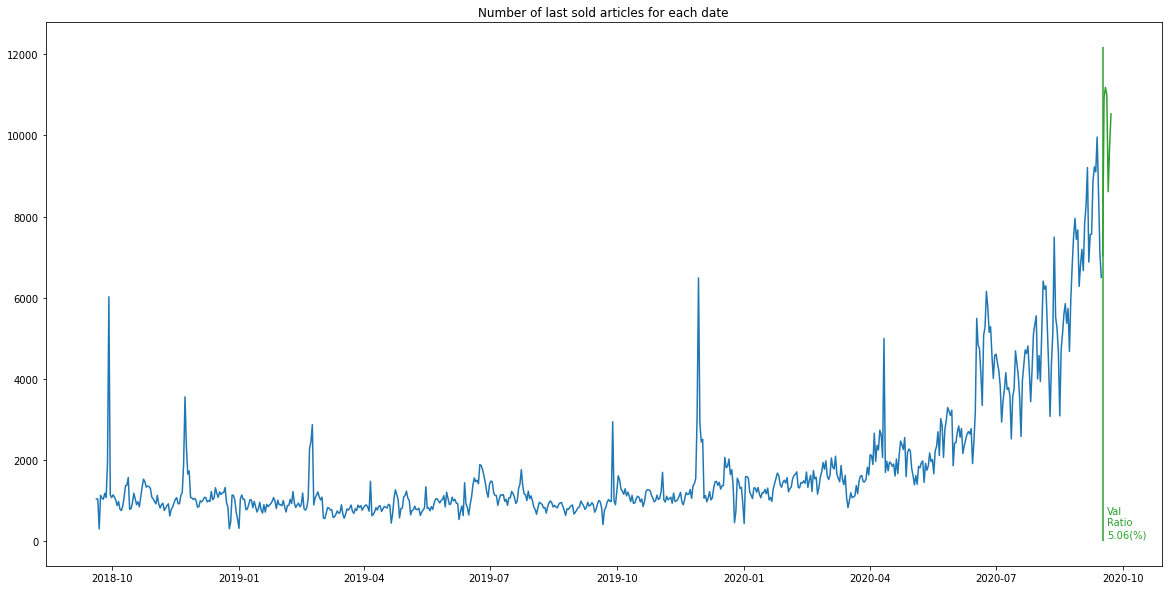

In [9]:
plt.figure(figsize = (20, 10))
plt.title('Number of last sold articles for each date')
sns.set_color_codes("pastel")

plt.plot('latest_date', 'counts',\
         data = latest_purchase_date_counts_df[latest_purchase_date_counts_df['latest_date']<last_one_week])
plt.plot('latest_date', 'counts', \
         data = latest_purchase_date_counts_df[latest_purchase_date_counts_df['latest_date']>=last_one_week],\
         color = sns.color_palette('tab10')[2])
plt.vlines(last_one_week, 0, max(latest_purchase_date_counts_df['counts'])+1000, color = sns.color_palette('tab10')[2])

validation_customer_ratio = \
    latest_purchase_date_counts_df[latest_purchase_date_counts_df['latest_date']>=last_one_week]\
    ['counts'].sum()/latest_purchase_date_counts_df['counts'].sum()
plt.text(last_one_week+timedelta(days=3), 100, 'Val\nRatio\n'+str(round(validation_customer_ratio*100, 2))+'(%)',\
         color = sns.color_palette('tab10')[2])
plt.show()

- 위 그래프는 한번이라도 구매경험이 있는 고객, 즉 article을 추천해야 되는 고객들 모두에 대해, 가장 마지막으로 구매를 한 날짜별로 몇명씩 있는지 나타낸 것이다. 예를 들면 2019년 09월 19일에 1,500명이 count되었다면 2019년 09월 19일이 마지막 구매날짜인 고객이 1,500명 있다는 의미이다.
- Competition에 제출물로, 한번이라도 구매경험이 있는 고객이라면 무조건 12개의 article을 추천해야된다. 하지만 test 데이터는 마지막 training 데이터 이후로 일주일간의 구매기록인데, competition 주최측에 따르면 해당 기간동안 구매기록이 없는 고객들은 성능 측정을 위한 metric 계산에서 제외된다고 한다. 이러한 test 환경을 최대한 비슷하게 구축하기 위해 validation 데이터에 대해서도 해당 기간동안 구매가 없다면 성능 측정을 위한 metric 계산에서 제외시킬 것이다. 그리고 이를 위해 마지막 구매기록이 validation 데이터에 포함되는 고객이 어느정도 있는지 살펴보기 위해 위와 같은 plot을 그려보았다.
- ***Validation 데이터에 포함되는 고객들, 즉 마지막 구매일자가 validation 데이터에 포함되는 고객들은 전체의 약 5.06%이다. training은 모든 고객들에 대해 진행할 예정이지만, validation 값 산정, 즉, 성능평가는 5% 남짓한 고객들을 대상으로 진행할 것이다.***

In [7]:
train = transactions[transactions['t_dat']<last_one_week].copy()
validation = transactions[transactions['t_dat']>=last_one_week].copy()

- 다만 위와 같이 training, validation 데이터를 나누어 모델을 만든다면, validation 기간에 처음 구매를 한 고객의 경우 제대로 된 학습이 진행되지 않을 것이다. 하여 validation 데이터를 사용하여 성능평가 metric으로 검증할 땐 해당 고객들을 제외하고 학습을 진행할 것이다. 아래와 같이 총 5,572명의 고객들이 그 제외 대상이다.

In [12]:
first_purchase = transactions.groupby('customer_id')['t_dat'].apply(lambda x: min(x))
first_purchase.loc[first_purchase>=last_one_week]

customer_id
000525e3fe01600d717da8423643a8303390a055c578ed8a97256600baf54565   2020-09-22
0008daf19b2a7cd6fa00836c717aa0f143c83d88c35e0269a28cbff53664205a   2020-09-19
0032c5c60cd449c55f51f0d49f45f8ba128d9e258ae00f7378fc7f00f1ecb3b2   2020-09-17
0037e7bd072811e71c2de6cfa8296198c05906dfcf3a59ba107b48b400460771   2020-09-21
003bb11f4a641d26e321b80c099618b2c1cf26fee040dda0a9d3713d2e5ada8a   2020-09-16
                                                                      ...    
ffbb641ba0e3264ab8b25f5e78630738ab59add1975086f35325d59aafd61069   2020-09-18
ffc6f889a579ecbce18c3b746306f4a62c50966ceab852d40b81c9b39e4b76a0   2020-09-16
ffd01795697785b1319b79e95176505a6a8367debbc964447dfaa634a1be7f7f   2020-09-20
ffefc8ff8c1151e8cc3ab029aea5b84d4433ad0041a49582869c3ee8c66f7ba1   2020-09-20
fff5bce65434cfe69148c6b7a44e86b4ba58e978d5c43d063106e2009438f089   2020-09-17
Name: t_dat, Length: 5572, dtype: datetime64[ns]

## 1. Candidates generate
    - 1-1. Same Product_code
    - 1-2. Weekly & Monthly & Age-wise Best-Seller
    - 1-3. Contents-based Filtering
    - 1-4. Graph Embedding(almost User-based Collaborative Filtering)
<hr>

- 이제 본격적으로 customer마다 추천할 후보군을 선정하는 작업을 진행할 것이다. 위의 목차에 적어놓은 바와 같이 4가지의 방법으로 candidate 후보군을 구성할 것이다. 각 방법마다 중첩되는 article이 있을 수 있기 때문에 set 형태로 저장하고 마지막에 중복을 제거한 형태로 합칠 것이다.

### 1-1. Same Product_code

- ```articles.csv```에 있는 모든 article들은 고유의 article_id를 가지고 있지만, 색깔이나 패턴은 다르지만 같은 article인 경우엔 product_code가 같다. 각 customer별로 최근 구매이력이 있는 article에 대해, product_code는 같지만 article_id는 다른, 즉 같은 제품이지만 색깔이나 패턴만 다른 article들을 candidate으로 삼을 것이다.
- ***해당 방식을 통해 상품에 만족했을 경우 같은 옷을 여벌로 구입하거나, 색깔이나 패턴만 다른 옷을 구매했을 가능성을 고려해줄 수 있다.***

In [ ]:
# 최근 구매 article 중 최대 3개까지만 뽑음.
recent_bought_articles = train.groupby('customer_id')['article_id'].apply(lambda x: list(x))
recent_bought_articles = recent_bought_articles.apply(lambda x: x[-3:])

recent_bought_articles_df = recent_bought_articles.reset_index()
recent_bought_articles_df.columns = ['customer_id', 'article_id']

In [ ]:
# 위에서 최대 3개까지 뽑은 article들에 대해, 같은 product_code를 가진 article들은 전부 set에 담아,
# 'same_pdcode_articles' column 생성
def same_product_code_articles(article_list):
    product_code_list = [] 
    same_product_code_articles_set = set()
    for article_id in article_list:
        product_code = articles[articles['article_id']==article_id]['product_code'].values[0]
        same_product_code_articles_set.update(articles[articles['product_code']==product_code]\
                                              ['article_id'].values)
    return same_product_code_articles_set

recent_bought_articles_df['same_pdcode_articles'] = recent_bought_articles_df['article_id']\
                                                    .apply(same_product_code_articles)

In [17]:
candidates = recent_bought_articles_df.drop(columns=['article_id'])
articles_length = recent_bought_articles_df['same_pdcode_articles'].apply(len)
min(articles_length), max(articles_length)

(1, 186)

- 각 고객마다 최소 1개, 최대 186개의 article들을 candidate으로 선정한다.

### 1-2. Weekly & Monthly & Age-wise Best-Seller

- <code>transactions.csv</code>에서 특정 기간 중 가장 많이 팔렸던 Best seller들을 Candidate으로 삼을 것이다. 특정기간은 validaion 데이터가 집계된 기간의 일주일, 한달 전으로 설정했다.
- 최근 일주일, 그리고 한달간 Best seller를 합친 집합인 (```best_set```)와 연령대별 (all time) best seller인 (```age_best```)를 candidate으로 삼았다.
- ***먼저, Best seller를 사용하는 이유는 앞서 ```1.EDA```notebook에서 확인한 바와 같이, 많은 고객들이 상품구매 횟수가 아주 적다(3회 이하가 전체의 25%, 1회 구매가 전체의 10%) 하여 구매기록에 따른 맞춤 추천보다는 인기있는 상품의 추천이 포함될 필요가 있다.***
- ***Best seller를 산정하는 기준으로 최근 일주일 및 한달간을 사용하는 이유는 앞서 ```1.EDA```notebook에서 확인한 바와 같이, 월별로 상품의 판매량 차이가 크고 또, 그러한 판매량 차이가 2년간 동일한 추이를 반복적으로 보여주기에, 시기별로 주요하게 판매되는 상품이 차이가 있을 것이기 때문이다.***
- ***연령대별 Best seller를 사용하는 이유는, 당연하게도 연령별로 착용하는 fashion item 차이가 있을 것이고, 앞서 ```1.EDA```notebook에서 확인한 바와 같이, 연령대별로 고객들이 비교적 고르게 퍼져있어, 동년배 고객들에게 인기있는 상품들을 추천해줄 수 있기 때문이다.***

In [ ]:
# validaion 기간 전 최근 일주일 및 한달 전
last_one_week_train = last_one_week + timedelta(weeks=-1)
last_one_month_train = last_one_week + timedelta(weeks=-4)
week_best = train[train['t_dat']>=last_one_week_train]['article_id'].value_counts()
month_best = train[train['t_dat']>=last_one_month_train]['article_id'].value_counts()

In [ ]:
# 각각 validation 한 주 전, 한달 전 기간동안 판매량 상위 50개씩을 지정해서, 중복을 없애는 set 데이터로 만듬
best_set = set()
best_set.update(week_best[:50].index.to_numpy())
best_set.update(month_best[:50].index.to_numpy())

# 연령대별 best item 선정
age_best_df = pd.merge(train, customers[['customer_id', 'age']], how = 'left', \
                       left_on = 'customer_id', right_on = 'customer_id')
age_best_df['age'] = age_best_df['age'].fillna(0)
age_best_df = age_best_df.groupby(['age'])['article_id'].value_counts()

In [ ]:
# 연령대별로 판매량 상위 50개씩을 지정해서, 위의 best_set과 합쳐 'best_articles' column으로 통합
age_best_dict = dict()
age_best_dict[0] = set(age_best_df[0][:50].index.to_numpy()).union(best_set)
for i in range(16, 100):
    age_best_dict[i] = set(age_best_df[i][:50].index.to_numpy()).union(best_set)
    
candidates = pd.merge(candidates, customers[['customer_id', 'age']], how = 'left', \
                      left_on = 'customer_id', right_on = 'customer_id')
candidates['age'] = candidates['age'].fillna(0)
candidates['best_articles'] = candidates['age'].apply(lambda x: age_best_dict[x])
candidates = candidates.drop(columns=['age'])

In [21]:
candidates.head()

,customer_id,same_pdcode_articles,best_articles
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"{795440001, 795440002, 795440003, 795440004, 7...","{579541001, 893141002, 885951001, 759871002, 9..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"{351484033, 351484034, 351484037, 351484039, 8...","{689109001, 579541001, 893141002, 759871001, 7..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"{794321001, 794321002, 794321003, 794321004, 7...","{689109001, 579541001, 689109003, 893141002, 7..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"{732413001, 732413002, 732413004, 732413005, 7...","{579541001, 893141002, 568597006, 885951001, 7..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"{730683010, 730683011, 730683012, 730683013, 7...","{579541001, 893141002, 568597006, 885951001, 7..."


### 1-3. Contents based Filtering

- Article의 column들을 모두 one-hot encoding한 후 cosine similarity를 계산하여, customer별로 최근 구매 article과 cosine similarity가 높은 article들을 candidate으로 선정할 것이다.
- ***해당 방법을 통해, 고객의 구매기록에 있는 article의 특성에 따라 유사한 article을 선정하여, 개인화된 추천 방법으로 가장 널리 쓰이는 방법 중 하나인 Contents based Filtering을 구현할 수 있다.***

In [22]:
pd.set_option('display.max_columns', None)
articles.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [23]:
articles_df = articles.drop(columns = ['product_code', 'prod_name', 'detail_desc', 'index_group_name', \
                                       'perceived_colour_value_name', 'index_name', 'perceived_colour_master_name',\
                                       'garment_group_name', 'graphical_appearance_name', 'colour_group_name',\
                                       'section_name', 'product_type_name', 'department_name'])

- 위에서 이미 사용한 column인 product_code와, code-name처럼 역할이 중복되는 column들을 drop한다.(code와 name이 같이 주어진 경우 name을 drop함)

In [ ]:
# One-hot encoding 진행
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(articles_df[articles_df.columns[1:]])

# 각 article별로, 다른 모든 article들에 대해 cosine similarity를 계산하고, cosine similarity 값이 높은 상위 50개씩을 선택
cos = cosine_similarity(enc.transform(articles_df[articles_df.columns[1:]]).toarray())
top_fifty_articles = np.argpartition(cos, -50)[:, -50:]
article_ids = articles['article_id']
article_id_map = lambda x: article_ids[x]
similar_articles = []
for i in range(len(top_fifty_articles)):
    similar_articles.append(set(article_id_map(top_fifty_articles[i]).values))

In [25]:
# 각 article마다 cosine similarity가 가장 높은 상위 50개씩을 'similar_articles' column으로 덧붙임.
similar_articles_series = pd.Series(similar_articles)
similar_articles_df = pd.concat([articles_df['article_id'], similar_articles_series], axis=1)
similar_articles_df.columns = ['article_id', 'similar_articles']

In [ ]:
# 최근 구매했던 article들에 대해 최대 3개까지, 가장 유사한 article들을 50개씩 추천
# 'recent_bought_articles_df'은 위에서 product_code를 사용하여 추천할 때 사용했던 최근 구매한 최대 3개까지의 article에 대한 변수이다.
def similar_article_recommender(article_list):
    similar_articles_to_recommend = set()
    for article_id in article_list:
        similar_articles_to_recommend.update(similar_articles_df[similar_articles_df['article_id']==article_id]\
                                             ['similar_articles'].values[0])
    return similar_articles_to_recommend

candidates['similar_articles'] = recent_bought_articles_df['article_id'].apply(similar_article_recommender)

In [27]:
candidates.head()

,customer_id,same_pdcode_articles,best_articles,similar_articles
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"{795440001, 795440002, 795440003, 795440004, 7...","{579541001, 893141002, 885951001, 759871002, 9...","{775328001, 862272001, 829717001, 717365001, 8..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"{351484033, 351484034, 351484037, 351484039, 8...","{689109001, 579541001, 893141002, 759871001, 7...","{699424001, 600043010, 850176003, 851680002, 6..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"{794321001, 794321002, 794321003, 794321004, 7...","{689109001, 579541001, 689109003, 893141002, 7...","{795243008, 863456001, 691072002, 617279005, 7..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,"{732413001, 732413002, 732413004, 732413005, 7...","{579541001, 893141002, 568597006, 885951001, 7...","{678688001, 741087001, 678687001, 625311008, 9..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"{730683010, 730683011, 730683012, 730683013, 7...","{579541001, 893141002, 568597006, 885951001, 7...","{630144001, 824928001, 719136001, 886720004, 8..."


In [30]:
# DataFrame을 numpy로 변환하여 저장
candidates_np = candidates.to_numpy()
np.save('./candidates_np.npy', candidates_np)

### 1-4. Graph Embedding(almost User-based Collaborative Filtering)

- 각 customer와 article을 node로 삼고 구매이력 여부에 따라 edge로 잇는 implicit feedback graph를 구성한 후, 이를 Graph Neural Network 모델을 통해 각 customer와 article을 벡터로 embedding하여 Collaborative Filtering을 진행할 것이다.(input: 구매이력, output: 고객과 article의 embedding된 벡터) 해당 모델은 같은 article을 구매한 다른 customer들이 어떤 article들을 구매했는지를 반영한다. 즉, 구매성향이 비슷한 다른 customer들의 정보를 기반으로 추천을 하는 것이다(user based collaborative filtering)
- ['Revisiting Graph based Collaborative Filtering: A Linear Residual Graph Convolutional Network Approach'](https://arxiv.org/abs/2001.10167)\[AAAI'20\] paper에서 제안한 모델을 사용하여 진행하였다.
- 해당 모델은 Pytorch, Numpy 및 기본 Python 라이브러리를 사용하여 학습을 진행하였다. [Github](https://github.com/newlei/LR-GCCF)에 원 저자가 제공한 코드가 있으나, 모델이나 loss function등의 이름을 잘못 적어놓거나, 일반적으로 Pytorch 모델을 정의하는 구조를 따르지 않는 등 가독성이 좋지않아 코드를 재구성하고 주석을 달아 학습을 진행하였다. Graph 모델의 학습과정만 해도 분량이 어느 정도 있기 때문에 별도의 notebook(```2-1.Graph embedding```)에서 학습을 진행시켰고, 현재 notebook에선 학습이 완료된 결과인 embedding된 벡터를 load하여 사용할 것이다.
- ***해당 방법을 통해 같은 article을 구매한 고객의(유사한 고객) 구매기록을 이용하여, 구매기록의 article과 연관없던 article까지 추천할 수 있다.***

In [ ]:
# Graph embedding을 진행할 때, customer와 article을 Label Encoder를 통해 integer로 변환하였기에,
# 다시 역변환하는 작업이 필요해서 아래의 함수들을 다시 사용한다.
customer_train_list = train['customer_id'].unique()
article_train_list = train['article_id'].unique()

le_customer = LabelEncoder()
le_article = LabelEncoder()

le_customer.fit(customer_train_list)
le_article.fit(article_train_list)

In [10]:
# 위에서 각 방법들(같은 product_code, best item, cosine similiarity 등)로 선정한 후보 article들을,
# {key: customer_id, value: article_id} 형태의 dictionary로 만든다.
candidates_np = np.load('candidates_np.npy', allow_pickle=True)

customer_candidates_dict = defaultdict(list)
for i in range(candidates_np.shape[0]):
    candidates_np[i][1].update(candidates_np[i][2])
    candidates_np[i][1].update(candidates_np[i][3])
    customer_candidates_dict[candidates_np[i][0]] = list(candidates_np[i][1])

In [11]:
# 총 100 epoch의 training 진행결과, validation recall이 가장 높았던 30epoch의 embedding 벡터를 load한다.
model = torch.load('./graph_training_result/30')
article_embedding_result = model.popitem()[1].clone().cpu().detach().numpy()
customer_embedding_result = model.popitem()[1].clone().cpu().detach().numpy()

In [ ]:
# training을 할 때 BPR(Bayesian Personalized Ranking) loss를 사용했는데,
# 이는 customer와 article간의 edge가 연결될 것 같으면(구매할 것 같으면), 두 벡터간 내적이 큰 값이 되도록 벡터를 embedding한다.
# 각 customer마다 모든 article의 vector들과 내적을 진행하여, 가장 내적값이 큰 100개를 후보 article로 선정하였다.
# 자세한 설명은 2-1.Graph embedding 노트북에 해놓았다.
# 해당 후보군들을 기존의 다른 방법들로 추출한 후보군들과 합쳐 'customer_candidates_dict'라는 후보군 dictionary를 만든다.
# 아래의 코드는 줄바꿈을 기준으로 3부분(~10,000, 10,000~1,350,000, 1,350,000~)으로 나누어져 있는데, 이는 사실 필수적인 과정은 아니다.
# 다만, 점점 몇몇 변수들의 용량이 막대해짐에 따라 해당 변수들을 읽어들이고 수정하는 데에 시간이 오래 걸리면서
# 처리시간이 기하급수적으로 늘어나게 되어 10,000개씩 나누어 처리하였다.

customer_candidates_dict = defaultdict(list)

matmul_cus_art = np.matmul(customer_embedding_result[:10000], article_embedding_result.T)
top_hundred_articles = np.argpartition(matmul_cus_art, -100)[:, -100:]
for idx in range(10000):
    customer_id_inverse = le_customer.inverse_transform([idx])[0]
    article_ids_inverse = le_article.inverse_transform(top_hundred_articles[idx])
    customer_candidates_dict[customer_id_inverse] = \
    customer_candidates_dict[customer_id_inverse] + list(article_ids_inverse)
    
for i in range(10000, customer_embedding_result.shape[0]-10000, 10000):
    matmul_cus_art = np.matmul(customer_embedding_result[i:i+10000], article_embedding_result.T)
    top_hundred_articles = np.argpartition(matmul_cus_art, -100)[:, -100:]
    for idx in range(i, i+10000):
        customer_id_inverse = le_customer.inverse_transform([idx])[0]
        article_ids_inverse = le_article.inverse_transform(top_hundred_articles[idx-i])
        customer_candidates_dict[customer_id_inverse] = \
        customer_candidates_dict[customer_id_inverse] + list(article_ids_inverse)
    
matmul_cus_art = np.matmul(customer_embedding_result[1350000:], article_embedding_result.T)
top_hundred_articles = np.argpartition(matmul_cus_art, -100)[:, -100:]
for idx in range(1350000, customer_embedding_result.shape[0]):
    customer_id_inverse = le_customer.inverse_transform([idx])[0]
    article_ids_inverse = le_article.inverse_transform(top_hundred_articles[idx-1350000])
    customer_candidates_dict[customer_id_inverse] = \
    customer_candidates_dict[customer_id_inverse] + list(article_ids_inverse)

np.save('./total_candidates.npy', [customer_candidates_dict])

## 2. Candidates Recall Test
    - Exclusive Candidates Test
    - Inclusive Candidates Test
<hr>

- 각 후보군을 나름 합리적인 방법으로 선정하였다고 생각하지만, 실제로 얼마나 '유효한' 아이디어였는지는 당연히 실험을 해봐야 알 수 있다. 후보군 선정은 앞으로 구매할 article들이 되도록 많이 후보군에 포함되는 방향으로 진행해야 한다. 그러므로 후보군의 유효성 실험에서는 validation 데이터에 포함된 article들(마지막 일주일간 고객들의 실구매 데이터)이 후보군에 얼마나 포함되어 있는지를 살펴볼 수 있는 recall 값을 사용할 것이다. validation 데이터에는 60,000명 이상의 고객들이 존재하는데, recall은 각 고객마다 값이 하나씩 존재하므로, validation 데이터에 존재하는 모든 고객들의 recall들을 평균내는 방식으로 각 candidate 후보군에 대한 성능측정을 진행할 것이다.
- 총 4개의 방법으로 candidate 후보군을 선정했으므로 4번의 실험을 진행하고, 하나씩 합쳐나가면서 살펴볼 것이다. 하나씩 합쳐보는 이유는 개인화되지 않은 ```best item``` 추천을 기초로 하여 구매 기록에 따라 개인화된 candidate 후보군 추천이 어느 정도의 성능 향상을 이끌어내는지 확인하기 위함이다. 각 cell별로 실행한 결과를 확인할 수 있으며 notebook 최하단에 그림으로 결과를 한번에 정리하였다.

In [14]:
# libaray 및 candidate load
from collections import defaultdict
from tqdm import tqdm

val_correct_np = validation[['customer_id', 'article_id']].groupby('customer_id')['article_id']\
                 .apply(np.array).reset_index().to_numpy()
candidates_np = np.load('candidates_np.npy', allow_pickle=True)

In [21]:
# val_correct_np에는 validation 데이터에 존재하는, 실제 고객들이 구매한 article이 numpy 형태로 담겨 있고,
# 이를 각 후보군이 담긴 dictionary와 함께 recall_mean 함수에 전달하면 recall_mean을 return하도록 한다.

def recall_mean(val_correct_np, candidate_dict):
    recall_list = list()
    for customer_id, article_array in tqdm(val_correct_np):
        recommended_articles = candidate_dict[customer_id]
        count = 0
        for article in article_array:
            if article in recommended_articles:
                count += 1
        if count == 0:
            recall_list.append(0)
        recall = count / len(article_array)
        recall_list.append(recall)

    recall_mean = np.array(recall_list).mean()
    return recall_mean

### Exclusive Candidates Test

In [23]:
# Weekly & Monthly Best articles
best_item_dict = defaultdict(list)
for i in range(candidates_np.shape[0]):
    best_item_dict[candidates_np[i][0]] = list(candidates_np[i][2])
best_item_recall = recall_mean(val_correct_np, best_item_dict)
print(best_item_recall)

100%|██████████████████████████████████| 68984/68984 [00:00<00:00, 74265.67it/s]

0.05802931188538974


In [24]:
# Same Product_code articles with recent 3 items
pdcode_dict = defaultdict(list)
for i in range(candidates_np.shape[0]):
    pdcode_dict[candidates_np[i][0]] = list(candidates_np[i][1])
pdcode_recall = recall_mean(val_correct_np, pdcode_dict)
print(pdcode_recall)

100%|█████████████████████████████████| 68984/68984 [00:00<00:00, 172791.39it/s]


0.023364310448528772


In [25]:
# Contents based Filtering (based on similiarity among articles)
cbf_dict = defaultdict(list)
for i in range(candidates_np.shape[0]):
    cbf_dict[candidates_np[i][0]] = list(candidates_np[i][3])
cbf_recall = recall_mean(val_correct_np, cbf_dict)
print(cbf_recall)

100%|██████████████████████████████████| 68984/68984 [00:01<00:00, 64223.41it/s]

0.021465912406311228


In [26]:
# Graph Collaborative Filtering
graph_embedding_recall = recall_mean(val_correct_np, customer_candidates_dict)
print(graph_embedding_recall)

100%|██████████████████████████████████| 68984/68984 [00:00<00:00, 79697.19it/s]

0.005040802440728277


### Inclusive Candidates Test

In [27]:
# Best articles + Same Product_code
pdcode_best_dict = defaultdict(list)
for i in range(candidates_np.shape[0]):
    candidates_np[i][1].update(candidates_np[i][2])
    pdcode_best_dict[candidates_np[i][0]] = list(candidates_np[i][1])
    
best_item_pdcode_recall = recall_mean(val_correct_np, pdcode_best_dict)
print(best_item_pdcode_recall,\
      'enhancement ratio:', best_item_pdcode_recall/best_item_recall*100-100, '%')

100%|██████████████████████████████████| 68984/68984 [00:01<00:00, 67616.74it/s]

0.08190470712279084 enhancement ratio: 41.14368146318188 %


- Weekly & Monthly Best candidates에 고객들의 최근 구매 데이터 중 같은 product_code를 가진 item들을 후보군으로 포함시켰을 때, validation 데이터에서 평균적으로 0.0819정도의 recall 값을 보임을 확인할 수 있다. 이는 weekly best + monthly best로만 이루어진 후보군에 비해 약 41% 정도 향상된 recall 값이다.

In [47]:
# Best articles + Same Product_code + Contents based filtering
plus_cbf_dict = defaultdict(list)
for i in range(candidates_np.shape[0]):
    candidates_np[i][1].update(candidates_np[i][2])
    candidates_np[i][1].update(candidates_np[i][3])
    plus_cbf_dict[candidates_np[i][0]] = list(candidates_np[i][1])
    
best_item_pdcode_cbf_recall = recall_mean(val_correct_np, plus_cbf_dict)
print(best_item_pdcode_cbf_recall,\
      'enhancement ratio:', best_item_pdcode_cbf_recall/best_item_pdcode_recall*100-100, '%')

100%|██████████████████████████████████| 68984/68984 [00:03<00:00, 22751.42it/s]

0.09037070050743094 enhancement ratio: 10.336394185437896 %


- 고객들의 최근 구매 article과 유사도가 높은 article을 후보군에 추가로 포함시켰을 때, validaion 데이터에서 평균으로 0.0903정도의 recall 값을 보임을 확인할 수 있다. 이는 weekly & monthly best + same product_code 후보군에 비해 약 10% 정도 향상된 recall 값이다.

In [48]:
# Best articles + Same Product_code + Contents based filtering + Graph collaborative filtering
plus_graph_embedding_dict = np.load('./total_candidates.npy', allow_pickle=True)[0]

best_item_pdcode_item_cf_graph_recall = recall_mean(val_correct_np, plus_graph_embedding_dict)
print(best_item_pdcode_item_cf_graph_recall,\
      'enhancement ratio:', best_item_pdcode_item_cf_graph_recall/best_item_pdcode_item_cf_recall*100-100, '%')

100%|██████████████████████████████████| 68984/68984 [00:03<00:00, 17883.86it/s]


0.09451372196325389 enhancement ratio: 4.584474207414459 %


- 고객들의 이전 article 구매기록을 반영하여 고객과 article간의 관계를 graph 형태로 반영하고, 이를 Graph Neural Network 모델을 통해 embedding하여 개인화된 article을 추천받을 때, validaion 데이터에서 평균적으로 0.0945정도의 recall 값을 보임을 확인할 수 있다. 이는 weekly & monthly best + same product_code + cbf filtering 후보군에 비해 약 4% 정도 향상된 recall 값이다.

### 성능 평가에 대한 고찰

- 위의 내용들을 정리하면 아래 그림과 같다.
- Weekly & monthly best article, 최근 구매한 article과 product_code가 같은 article을 사용하는 등의 비교적 간단한 방식을 통해 산출된 후보군들이 보여준 recall 값에 비해, article별로 label encoding을 진행하고 이에 대해 cosine similiarity를 구한다던가(Contents based filtering), Graph Neural Network을 이용해서 embedding을 진행한 후 article에 대한 추천을 하는 등 compuational cost가 상당히 비싼(즉, 복잡하고 오랜 시간을 요하는) 모델에서 투입한 리소스에 비해 recall 값의 향상이 비교적 더디다고 느껴질 수 있다. 
- 이는 일정 구간 이상부터 투입되는 input 대비 output의 '가성비'가 점점 떨어지는 한계효용의 법칙처럼, 최근 구매기록으로 이미 간단하고 강력한 performance를 얻어낼 수 있는 방법의 사용 이후, 그 이상의 관계를 포착해내는 것은 투입되는 시간과 컴퓨팅 리소스 대비 성능 향상이 더뎌보일 수 있다. 하지만 이렇게 추출된 후보군들, 특히 가장 많은 시간을 들여 계산을 진행했던 graph neural network을 이용했던 방식은 기존 후보군들과 겹치는 부분이 거의 없이 성능향상에 기여할 수 있었다.

![recall mean result](./images/candidates_average_recall.png)

- 평균 Recall이 0.0945가 나왔다는 말은 어떤 고객이 상품을 구매했을 때 평균적으로 약 9.45% 확률로 해당 상품이 candidate에 포함되어 있다는 것을 의미한다. 이게 어느 정도 수치인지는 당연히 상대적일 수밖에 없어서 설명을 덧붙이자면, 해당 Kaggle competition의 최종 우승자가 제출한 모델의 test 데이터에 대한 MAP@12가 0.037 정도였다.
- 물론 1) MAP@12는 12개만 추천하여 산출한 수치이고 candidate에는 수백개의 article 후보군이 있다. 그리고 2) MAP는 Mean Average Precision으로 어디까지나 기본적인 계산방식은 precision이라 recall과는 직접적인 비교가 불가능하긴 하다.  
    하지만 1) 12개와 수백개의 간극은 ranking 모델에서 한번 더 정교화된 추천을 진행할 것이므로 극복할 여지가 다분하다. 2) precision과 recall은 분명 다르긴 하지만, metric을 적용할 때 분모에 포함되는 요소는 달라도 분자에 포함되는 요소는 같다. 따라서 산출한 평균 recall의 수치도 최종적으로 사용해야 할 metric인 MAP와 충분한 상관관계가 존재한다.
- ***결론적으로 candiate 후보군이 얼마나 잘 선정되었는지 수치적으로 직접적인 비교는 힘들지만, 간접적으로 추측해본 바로는 ranking 모델까지 훈련을 잘 시킨다면 유의미한 결과를 기대해볼 수 있겠다.***